### Data Driven Vs Model-Driven methods 

Suppose you want to measure the electricity demand of a city in the future. 
- Model-Driven Methods
<p style="text-align: center;"><b>$ED = f(current temperature, strength of economy, population, time of day, day of week, error)$ </b></p>

- Data-Driven methods
<p style="text-align: center;"><b>$ED_{t+1}=f(Y_{t},Y_{t−1},Y_{t−2},Y_{t−3},…,error)$</b></p>

- Mixed Methods
<p style="text-align: center;"><b>$ED_{t+1}=f(Y_{t}, current, temperature, strength of economy, population, time of day, day of week, error)$</b></p>

In [10]:
import pandas as pd
import numpy as np
import datetime
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
%matplotlib inline 

ts = pd.read_csv("data/AusAntidiabeticDrug.csv")
ts["ds"] = pd.to_datetime(ts["ds"])
ts.index = ts["ds"]
ts = ts[["y"]]
print(ts.shape)
ts.head()

(204, 1)


,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


## Split the data into train and test

In [11]:
x_train = ts[ts.index <datetime.datetime(2005, 1, 1, 0, 0, 0)]
x_test = ts[ts.index >=datetime.datetime(2005, 1, 1, 0, 0, 0)]
print(x_train.shape, x_test.shape)

(162, 1) (42, 1)


## Algorithms:
- Simple Moving Averages
- Simple Exponential Smoothing
- Holts Method (Trend)
- Holts-Winter Method (Trend and Seasonality)
- ARIMA Models

## Simple Moving Averages 
- Basically used to smooth the curve and remove random-fluctuations
- Good for forecasting when there is no clear trend and seasonality in the data 
- Choose n by checking for auto-correlation in the series. 

\begin{equation*}
T_{t+1} = (1/m)(\sum_{k=1}^m\  T_{t-k})
\end{equation*}

In [12]:
def simple_mv(price_train, price_valid, n = 12):
    """ Moving Average Function
    Input:
    ------
    Price_train: the train data on which you want to run moving average
    Price_valid: mainly to know the length of predictions you need to make. use validation data while validating and test_Data dataframe while Predicting.
    alpha: weight parameter
    n: the number of previous datapoints to consider.
    Function:
    --------
    F(t+1) =  (F(t)  + F(t-1) + F(t-2) + .....F(t-n))/n
    Returns:
    -------
    A list with predictions. 
    """
    if price_valid is None:
        total_length = len(price_train)
    else:
        total_length = len(price_train)+len(price_valid)

    pred =[]
    for i in range(total_length):
        if i < n:
            pred.append(0)
        elif i <= len(price_train):
            x = price_train[i-n:i]
            pred.append(np.mean(x))
        else:
            x = pred[-n:]
            pred.append(np.mean(x))
    return pred

In [35]:
pred = simple_mv(x_train.values, x_test.values, n=12)
pred = pd.DataFrame(pred)
pred.columns = ["yhat"]
pred.index = ts.index
pred.head()
measure = math.pow(mean_squared_error(x_test.values, pred[pred.index >=datetime.datetime(2005, 1, 1, 0, 0, 0)].values), 0.5)
print(measure)

6.460844497482257


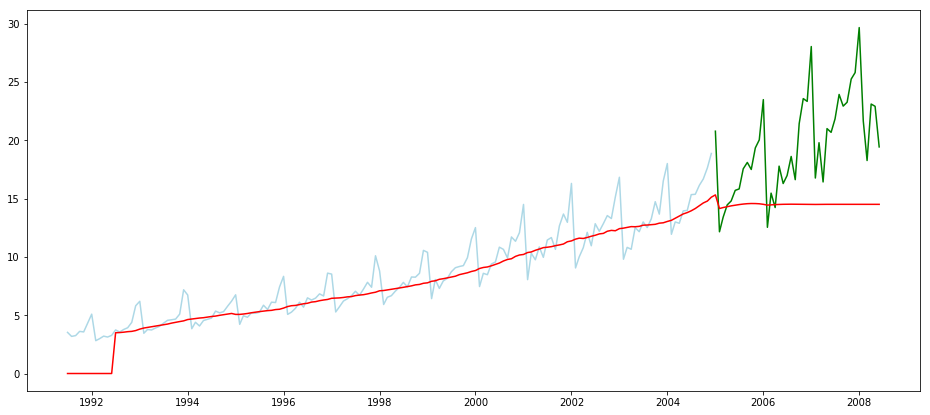

In [36]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

## Simple Exponential Smoothing 

- The simplest of the exponentially smoothing methods is naturally called “simple exponential smoothing”.
- This method is suitable for forecasting data with no clear trend or seasonal pattern. 

\begin{equation*}
F_{t+1} = \alpha * F_{t}  + \alpha * (1 - \alpha) * F_{t-1} + \alpha * (1 - \alpha)^2 * F_{t-2} + .....N
\end{equation*}

Here $\alpha$ and n are two hyper-parameter which needs to be tuned using the validation set 

In [37]:
def ses(price_train, price_valid, alpha =0.2, n = 27):
    """ Moving Average Function
    Input:
    ------
    Price_train: the train data on which you want to run moving average
    Price_valid: mainly to know the length of predictions you need to make. use validation data while validating and test_Data dataframe while Predicting.
    alpha: weight parameter
    n: the number of previous datapoints to consider.
    Function:
    --------
    F(t+1) = alpha * F(t)  + alpha * (1 - aplha) * F(t-1) + alpha * (1 - alpha)^2 * F(t-2) + .....N
    Returns:
    -------
    A list with predictions. 
    """
    if price_valid is None:
        total_length = len(price_train)
    else:
        total_length = len(price_train)+len(price_valid)

    pred =[]
    for i in range(total_length):
        if i < n:
            pred.append(0)
        elif i <= len(price_train):
            x = price_train[i-n:i]
            val = []
            for i in range(len(x)):
                m = (alpha)*((1-alpha)**i)*(x[-i])
                val.append(m)
            pred.append(np.sum(val))
        else:
            x = pred[-n:]
            val = []
            for i in range(len(x)):
                m = (alpha)*((1-alpha)**i)*(x[-i])
                val.append(m)
            pred.append(np.sum(val))
    return pred

In [38]:
## Apply a Grid search to find the best model,
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    pred = ses(x_train.values, x_test.values, alpha=i, n=12)
    pred = pd.DataFrame(pred)
    pred.columns = ["yhat"]
    pred.index = ts.index
    measure = math.pow(mean_squared_error(x_test.values, pred[pred.index >=datetime.datetime(2005, 1, 1, 0, 0, 0)].values), 0.5)
    print("alpha: {} RMSE:{}".format(i,measure))

alpha: 0.1 RMSE:16.902737191795765
alpha: 0.2 RMSE:10.506228033620037
alpha: 0.3 RMSE:7.13184832363266
alpha: 0.4 RMSE:6.401425561453352
alpha: 0.5 RMSE:6.413902122085201
alpha: 0.6 RMSE:6.5312701370431565
alpha: 0.7 RMSE:6.660698278269404
alpha: 0.8 RMSE:6.816660260629047
alpha: 0.9 RMSE:6.993417647272655


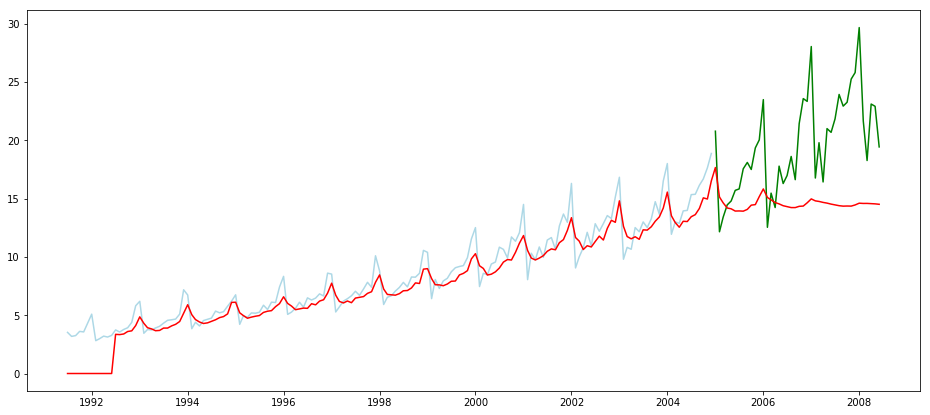

In [39]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
pred = pd.DataFrame(ses(x_train.values, x_test.values, alpha=0.4, n=12))
pred.columns = ["yhat"]
pred.index = ts.index
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

## Holts - Linear Model (Trend)
**Holt (1957)** extended simple exponential smoothing to allow the forecasting of data with a trend. This method involves a forecast equation and two smoothing equations (one for the level and one for the trend):

\begin{equation*}
ForecastEquation: \ yhat_{t+h/t} = l_{t}+h * b_{t} 
\end{equation*}
\begin{equation*}
Level Equation: \  l_{t} = \alpha * y_{t} +(1-\alpha)*(y_{t-1}+b_{t-1})
\end{equation*}
\begin{equation*}
Trend Equation: \  b_{t} = \beta ∗ (l_{t}−l_{t−1}) + (1−\beta)∗b_{t−1}
\end{equation*}


- The forecast function is no longer flat but trending. 
- The $h$-step-ahead forecast is equal to the last estimated level plus $h$-times the last estimated trend value. Hence the forecasts are a linear function of $h$.

In [41]:
"""https://gist.github.com/andrequeiroz/5888967
"""
from __future__ import division
from sys import exit
from math import sqrt
from numpy import array
from scipy.optimize import fmin_l_bfgs_b

def RMSE(params, *args):
    Y = args[0]
    type = args[1]
    rmse = 0
    if type == 'linear':
        alpha, beta = params
        a = [Y[0]]
        b = [Y[1] - Y[0]]
        y = [a[0] + b[0]]
        
        for i in range(len(Y)):
            a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
            b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
            y.append(a[i + 1] + b[i + 1])
    else:
        alpha, beta, gamma = params
        m = args[2]
        a = [sum(Y[0:m]) / float(m)]
        b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
        
        if type == 'additive':
            s = [Y[i] - a[0] for i in range(m)]
            y = [a[0] + b[0] + s[0]]
            
            for i in range(len(Y)):
                a.append(alpha * (Y[i] - s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] - a[i] - b[i]) + (1 - gamma) * s[i])
                y.append(a[i + 1] + b[i + 1] + s[i + 1])
        
        elif type == 'multiplicative':
            s = [Y[i] / a[0] for i in range(m)]
            y = [(a[0] + b[0]) * s[0]]
            
            for i in range(len(Y)):
                a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
                y.append((a[i + 1] + b[i + 1]) * s[i + 1])
        else:
            exit('Type must be either linear, additive or multiplicative')
    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y, y[:-1])]) / len(Y))
    return rmse

In [42]:
def linear(x, fc, alpha = None, beta = None):
    Y = x[:]
    if (alpha == None or beta == None):
        initial_values = array([0.3, 0.1])
        boundaries = [(0, 1), (0, 1)]
        type = 'linear'
        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type), bounds = boundaries, approx_grad = True)
        alpha, beta = parameters[0]
    
    a = [Y[0]]
    b = [Y[1] - Y[0]]
    y = [a[0] + b[0]]
    rmse = 0
    
    for i in range(len(Y) + fc):
        if i == len(Y):
            Y.append(a[-1] + b[-1])
        a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        y.append(a[i + 1] + b[i + 1])
    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))
    return Y[-fc:], alpha, beta, rmse

In [48]:
pred , alpha, beta, rmse =linear(list(x_train.values), len(x_test.values))
print(len(pred), alpha, beta, rmse)

42 0.432615819808 0.0401462774444 1.4744216577126246


4.034449767941766


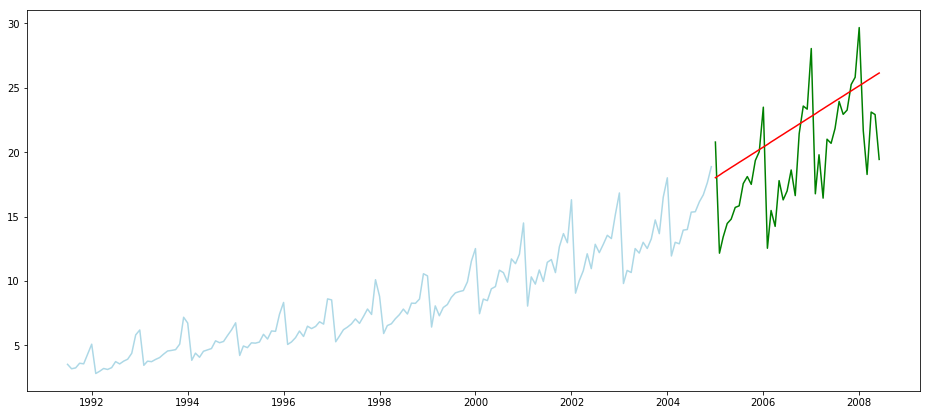

In [52]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
pred = pd.DataFrame(pred)
pred.columns = ["yhat"]
pred.index = x_test.index
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

## Holts Winter Method
- Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. 
- The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — 
    - one for the **level** $l_{t}$ 
    - one for the **trend** $b_{t}$, and
    - one for the **seasonal** component $s_{t}$, 
 
with corresponding smoothing parameters $\alpha$, $\beta$  and $\gamma$. We use  $m$ to denote the frequency of the seasonality, i.e., the number of seasons in a year.  

For example, for quarterly data  $m$=4, and for monthly data $m$=12


## The Additive Method
\begin{align*}
  \hat{y}_{t+h|t} = \ell_{t} + hb_{t} + s_{t-m+h_{m}^{+}} \\
  \ell_{t} = \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} = \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} = \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}\

## The Multiplicative Method
\begin{align*}
  \hat{y}_{t+h|t} = (\ell_{t} + hb_{t})s_{t-m+h_{m}^{+}}. \\
  \ell_{t} = \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} = \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} = \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}
\end{align*}\

In [54]:
def multiplicative(x, m, fc, alpha = None, beta = None, gamma = None):
    
    Y = x[:]
    
    if (alpha == None or beta == None or gamma == None):
        
        initial_values = array([0.0, 1.0, 0.0])
        boundaries = [(0, 1), (0, 1), (0, 1)]
        type = 'multiplicative'
        
        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type, m), bounds = boundaries, approx_grad = True)
        alpha, beta, gamma = parameters[0]
    
    a = [sum(Y[0:m]) / float(m)]
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
    s = [Y[i] / a[0] for i in range(m)]
    y = [(a[0] + b[0]) * s[0]]
    rmse = 0
    
    for i in range(len(Y) + fc):
        
        if i == len(Y):
            Y.append((a[-1] + b[-1]) * s[-m])
        
        a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
        y.append((a[i + 1] + b[i + 1]) * s[i + 1])
    
    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))
    
    return Y[-fc:], alpha, beta, gamma, rmse

In [56]:
pred , alpha, beta, gamma, rmse =multiplicative(list(x_train.values), 12, len(x_test.values))
print(len(pred), alpha, beta, rmse)

42 0.188258842638 0.0529014597158 0.5004130530199231


1.7868621621198282


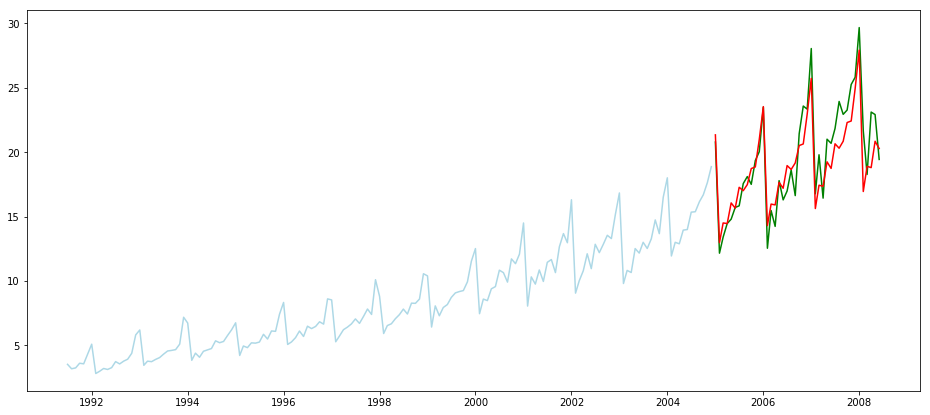

In [57]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
pred = pd.DataFrame(pred)
pred.columns = ["yhat"]
pred.index = x_test.index
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

In [ ]:
## ARIMA Models 